# Import libraries


In [1]:
# Suppressing Warnings

import warnings
warnings.filterwarnings('ignore')

# Import libraries
import tweepy
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

%matplotlib inline

# Get authentication data

In [2]:
# Load the authentication data
log = pd.read_excel('keys.xlsx')

In [3]:
# Get twitter API credentials
consumer_key = log['ConsumerKey'][0]
consumer_secret = log['ConsumerKeySecret'][0]
access_token = log['AccessToken'][0]
access_token_secret = log['AccessTokenSecret'][0]

# Create API object with credentials

In [4]:
# Create the authentication object
authenticate = tweepy.OAuthHandler(consumer_key, consumer_secret)

In [5]:
#Set the access token and access token secret
authenticate.set_access_token(key = access_token, secret = access_token_secret)

In [6]:
# Create API object
api = tweepy.API(auth_handler = authenticate, wait_on_rate_limit = True)

# Obtain data from the api

To get data from the api using this method you need to have a developer account on the twitter developer portal, as well as a minimum permission level of 'elevated'. 

If you have an 'essential' permission level, this code will not work for you so you have to make a request to have your permissions extended through the developer portal. Once this is done, you will be able to run this code with your login credentials.

## Getting info from user

Extracting data from user (elonmusk) making a loop to get it's name, description, location, followers_count and friends_count. The data is stored in a dictionary which is then converted into a dataframe.

In [7]:
user_list = ['elonmusk']

# Getting info from bio
for user in user_list:
  user_info = api.get_user(user)
  name = user_info.name
  description = user_info.description
  location = user_info.location
  followers_count = user_info.followers_count
  friends_count = user_info.friends_count

  user_info = {
      'Name':[name],
      'Bio':[description],
      'Location':[location],
      'Followers_count':[followers_count],
      'Friends_count':[friends_count]
  }

# Saving data into a dataframe
info = pd.DataFrame(user_info)

In [8]:
# Print dataframe with user_info 
info

,Name,Bio,Location,Followers_count,Friends_count
0,Elon Musk,,,130276321,181


## Extracting 3500 tweets

Getting tweets, along with the number of likes, retweets and date of creation.

In [9]:
# Number of tweets to extract
number_of_tweets = 3500

# Creating empty lists to import data
tweets = []
retweets = []
likes = []
time = []

# Looping throught every tweet to obtain full text, retweets, likes and date of creation
for i in tweepy.Cursor(api.user_timeline, id = 'elonmusk', include_rts = False, tweet_mode = 'extended', lang = 'en').items(number_of_tweets):
  tweets.append(i.full_text)
  retweets.append(i.retweet_count)
  likes.append(i.favorite_count)
  time.append(i.created_at)

In [10]:
df = pd.DataFrame({'Tweets':tweets,'Retweets':retweets,'Likes':likes,'Date':time})

In [11]:
df

,Tweets,Retweets,Likes,Date
0,"@Teslaconomics So many NN’s, the visualizer to...",97,1450,2023-03-02 12:26:07
1,@RichardDawkins This is insane,151,2153,2023-03-02 11:38:33
2,@BillyM2k 🤣💯,158,2781,2023-03-02 07:59:49
3,The ability of Twitter advertising to reach th...,5739,58421,2023-03-02 07:46:06
4,@Teslaconomics Cybertruck cruisers will be nex...,709,13740,2023-03-02 07:27:08
...,...,...,...,...
3012,@stillgray @jack Exactly,273,7960,2022-11-07 03:35:15
3013,@jack Not everything needs to have “bird” in t...,1406,26770,2022-11-07 03:15:36
3014,@jack Birdwatch gives me the creeps,985,22041,2022-11-07 03:07:29
3015,@SarahKSilverman Community Notes aka @birdwatch,268,7372,2022-11-07 03:06:19


In [12]:
df.to_csv('rawdata.csv', index = False)

# Data cleaning

## Text cleaning

In [13]:
# Creating a function to clean the tweets

def cleantwt (twt):
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

  twt = re.sub('RT', '', twt) # remove 'RT' from tweets
  twt = re.sub('#[A-Za-z0-9]+', '', twt) # remove the '#' from the tweets
  twt = re.sub('\\n', '', twt) # remove the '\n' character
  twt = re.sub('https?:\/\/\S+', '', twt) # remove the hyperlinks
  twt = re.sub('@[\S]*', '', twt) # remove @mentions
  twt = re.sub('^[\s]+|[\s]+$', '', twt) # remove leading and trailing whitespaces
  twt = re.sub(emoj, '', twt) # remove emojis
  return twt

In [14]:
# Create a new column with the cleaned tweets

df['Cleaned_Tweets'] = df['Tweets'].apply(cleantwt)

In [15]:
# Showing the data
df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,"@Teslaconomics So many NN’s, the visualizer to...",97,1450,2023-03-02 12:26:07,"So many NN’s, the visualizer tool crashes tryi..."
1,@RichardDawkins This is insane,151,2153,2023-03-02 11:38:33,This is insane
2,@BillyM2k 🤣💯,158,2781,2023-03-02 07:59:49,
3,The ability of Twitter advertising to reach th...,5739,58421,2023-03-02 07:46:06,The ability of Twitter advertising to reach th...
4,@Teslaconomics Cybertruck cruisers will be nex...,709,13740,2023-03-02 07:27:08,Cybertruck cruisers will be next-level. Design...


Some of the tweets only contained mentions or emojis, so when I applied the cleanup to the dataframe, some rows were left with empty strings in the 'Cleaned_tweets' column. Now, I'm going to delete them.

In [16]:
# Drop rows with empty strings ('')

df.drop(df[df['Cleaned_Tweets'] == ''].index, inplace = True)

In [17]:
# Show dataframe with clean tweets column
df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,"@Teslaconomics So many NN’s, the visualizer to...",97,1450,2023-03-02 12:26:07,"So many NN’s, the visualizer tool crashes tryi..."
1,@RichardDawkins This is insane,151,2153,2023-03-02 11:38:33,This is insane
3,The ability of Twitter advertising to reach th...,5739,58421,2023-03-02 07:46:06,The ability of Twitter advertising to reach th...
4,@Teslaconomics Cybertruck cruisers will be nex...,709,13740,2023-03-02 07:27:08,Cybertruck cruisers will be next-level. Design...
5,Twice as many people died in Japan last year a...,14903,76109,2023-03-02 02:57:31,Twice as many people died in Japan last year a...


## Removing duplicates

In [18]:
# Counting duplicate data in dataframe

df.duplicated().sum()

0

There are no duplicates in the dataframe, so I can start with the analysis.

In [19]:
df.to_csv('cleandata.csv', index = False)

In [20]:
shape = df.shape

print(f"There are {shape[0]} tweets after the cleanup.")

There are 2589 tweets after the cleanup.


# Sentiment Analysis

A very accurate definition of polarity and subjectivity in sentiment analysis is the following, provided by Christian Meyer on [Quora](https://www.quora.com/What-is-polarity-and-subjectivity-in-sentiment-analysis). 

* **Polarity** refers to the strength of an opinion. It could be positive or negative. If something has a strong positive feeling or emotion associated with it, such as admiration, trust, love; this will indeed have a certain orientation towards all other aspects of that object’s existence. The same goes for negative polarities. A good example would be the following: ‘I don’t think I’ll buy this item because my previous experience with a similar item wasn’t so good.’ That will have a negative polarity.

* **Subjectivity** refers to the degree to which a person is personally involved in an object. What matters the most here are personal connections and individual experiences with that object, which may or may not differ from someone else’s point of view. For example: ‘I’m very happy with my new smartphone because it has the highest performance available on the market.’ Similarly to polarity, strong subjectivity may be negative or positive. The statement here is clearly subjective because the user is actually talking about his experience and how he feels about an object.

Having clarified this, I will start the analysis by calculating the polarity and subjectivity of each tweet in the dataframe.

## Getting subjectivity and polarity

In [21]:
#Create a function to get the subjectivity
def getSubjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity

#Create a function to get the polarity
def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity

In [22]:
#Create two new columns to save the results of the created functions 
df['Subjectivity'] = df['Cleaned_Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Cleaned_Tweets'].apply(getPolarity)

In [23]:
#Show the data
df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets,Subjectivity,Polarity
0,"@Teslaconomics So many NN’s, the visualizer to...",97,1450,2023-03-02 12:26:07,"So many NN’s, the visualizer tool crashes tryi...",0.500000,0.500000
1,@RichardDawkins This is insane,151,2153,2023-03-02 11:38:33,This is insane,1.000000,-1.000000
3,The ability of Twitter advertising to reach th...,5739,58421,2023-03-02 07:46:06,The ability of Twitter advertising to reach th...,0.308333,0.041667
4,@Teslaconomics Cybertruck cruisers will be nex...,709,13740,2023-03-02 07:27:08,Cybertruck cruisers will be next-level. Design...,0.000000,0.000000
5,Twice as many people died in Japan last year a...,14903,76109,2023-03-02 02:57:31,Twice as many people died in Japan last year a...,0.283333,0.250000


In [24]:
# Creating a function to classify or label the sentiments as negative, positive and neutral
def getSentiment(value):
  if value < 0:
    return 'Negative'
  elif value > 0:
    return 'Positive'
  else:
    return 'Neutral'

In [25]:
# Create a new column 'Sentiment'
df['Sentiment'] = df['Polarity'].apply(getSentiment)

In [26]:
#show data
df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets,Subjectivity,Polarity,Sentiment
0,"@Teslaconomics So many NN’s, the visualizer to...",97,1450,2023-03-02 12:26:07,"So many NN’s, the visualizer tool crashes tryi...",0.500000,0.500000,Positive
1,@RichardDawkins This is insane,151,2153,2023-03-02 11:38:33,This is insane,1.000000,-1.000000,Negative
3,The ability of Twitter advertising to reach th...,5739,58421,2023-03-02 07:46:06,The ability of Twitter advertising to reach th...,0.308333,0.041667,Positive
4,@Teslaconomics Cybertruck cruisers will be nex...,709,13740,2023-03-02 07:27:08,Cybertruck cruisers will be next-level. Design...,0.000000,0.000000,Neutral
5,Twice as many people died in Japan last year a...,14903,76109,2023-03-02 02:57:31,Twice as many people died in Japan last year a...,0.283333,0.250000,Positive


## Visualizing the results

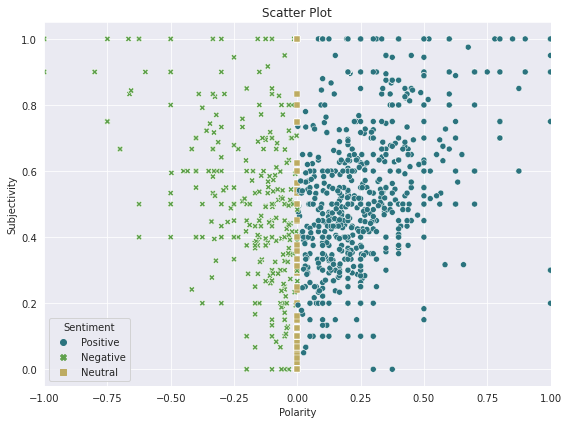

In [27]:
# Create scatter plot
sns.set_style('darkgrid')
plt.figure(figsize = (8,6))

markers = {'Positive':'o', 'Neutral':'s','Negative':'X'}

sns.scatterplot(data=df, x='Polarity', y='Subjectivity', hue = 'Sentiment', style = 'Sentiment', markers = markers, palette = 'gist_earth').set(xlim=(-1,1))
plt.title('Scatter Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.tight_layout()

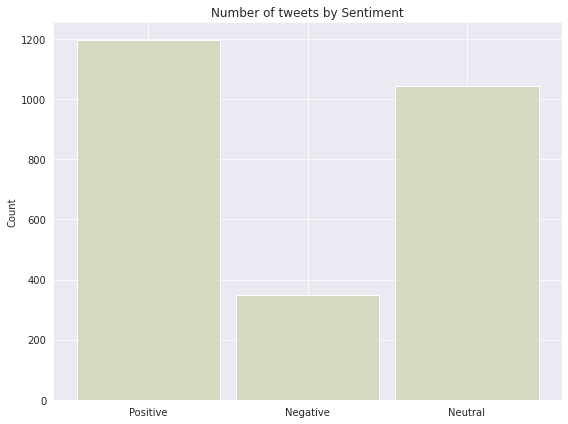

In [28]:
# Create a bar chart to count tweets according to its sentiment value

plt.figure(figsize = (8,6))

sns.histplot(df, x = 'Sentiment', color = '#ccd5ae', shrink = 0.9).set(xlabel = None)
plt.title('Number of tweets by Sentiment')

plt.tight_layout()

According to the data, most of Elon Musk's tweets are highly subjective and are perceived as positive or neutral.

In [29]:
# Creating month and year columns for time analysis
df['Month'] = pd.DatetimeIndex(df['Date']).month

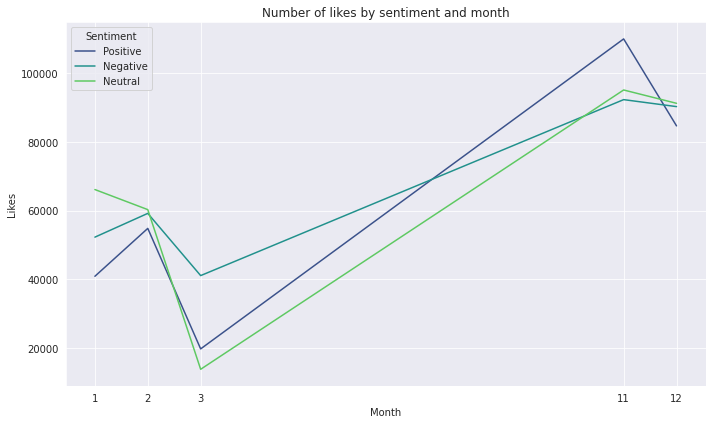

In [30]:
# Creating a plot to show number of likes depending on sentiment through time

plt.figure(figsize = (10, 6))

months = df['Month'].unique()

sns.lineplot(x = 'Month', y = 'Likes', hue = 'Sentiment', ci = None, data = df, palette = 'viridis')
plt.title('Number of likes by sentiment and month')
plt.xlabel('Month')
plt.xticks(ticks = [m for m in months])

plt.tight_layout()

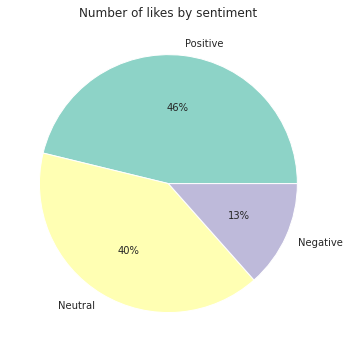

In [31]:
plt.figure(figsize = (10, 5))

data = df['Sentiment'].value_counts()
colors = sns.color_palette('Set3')
labels = ['Positive', 'Neutral', 'Negative']

plt.pie(data, labels = labels, autopct = '%.0f%%', colors = colors)
plt.title('Number of likes by sentiment')

plt.tight_layout()

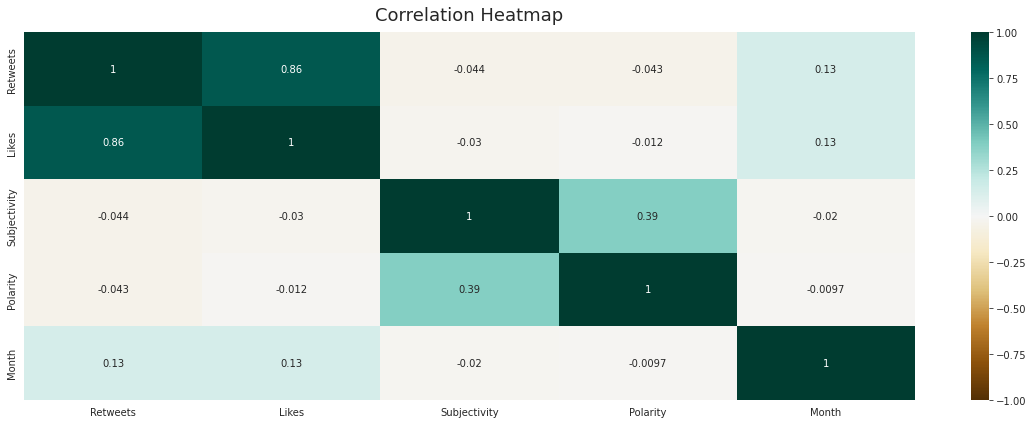

In [32]:
# Create correlation matrix to see correlation coefficients between sets of variables
plt.figure(figsize=(16, 6))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

plt.tight_layout()

Apparently likes and retweets have a strong positive linear relationship. On the other hand, subjectivity and polarity have a slight positive relationship.

# Text Analysis

## Copy dataframe

Now, I am going to analyze which are the most mentioned words, people and organizations. To do this, I will create a new dataframe with the tweets column and I will clean and transform it again but following other steps, since in the previous cleanup mentions to people were eliminated.

In [33]:
# Create new dataframe 'tx' with Tweets column
tx = df[['Tweets']].copy()

In [34]:
tx.head()

,Tweets
0,"@Teslaconomics So many NN’s, the visualizer to..."
1,@RichardDawkins This is insane
3,The ability of Twitter advertising to reach th...
4,@Teslaconomics Cybertruck cruisers will be nex...
5,Twice as many people died in Japan last year a...


Note that numbers are missing in the index. This is because, in the dataframe from which we are taking the data, those tweets where removed as they contained only emojis or a mention. 

Since those tweets did not have interesting content (they were only replies to users), I decided not to include them for the text analysis. Therefore, I will reset the index.

In [35]:
# Reset index
tx.reset_index(drop = True, inplace = True)

## Clean and split the text

In [36]:
# Creating a function to clean the tweets (similar to cleantwt without cleaning the mentions)

def cleantext (text):
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

  text = re.sub('https?:\/\/\S+', '', text) # remove the hyperlinks
  text = re.sub('^[\s]+|[\s]+$', '', text) # remove leading and trailing whitespaces
  text = re.sub(emoj, '', text) # remove emojis
  return text

In [37]:
# Create a new column with the cleaned text

tx['Cleaned_Text'] = tx['Tweets'].apply(cleantext)

In [38]:
tx = tx['Cleaned_Text']

# Save all tweets in a list

all_tweets = []

for tweet in tx:
  all_tweets.append(tweet)


# Split tweets in a list of words

lines = list()
for line in all_tweets:
  words = line.split()
  for w in words:
    lines.append(w)

In [39]:
# Print a sample
print(lines[0:10])

['@Teslaconomics', 'So', 'many', 'NN’s,', 'the', 'visualizer', 'tool', 'crashes', 'trying', 'to']


In [40]:
# Remove punctuation from the list
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]

# Assign all words, except those containing empty string characters, to a new list
lines2 = []

for word in lines:
  if word != '':
    lines2.append(word)

In [41]:
# Print a sample
print(lines2[0:10])

['Teslaconomics', 'So', 'many', 'NNs', 'the', 'visualizer', 'tool', 'crashes', 'trying', 'to']


## Stemming and removing Stop Words

Now that I have removed the punctuations from the list, it remains to stem each word to its root.

Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. 

For example, a stemmer for English operating on the stem cat should identify such strings as cats, catlike, and catty [(wikipedia)](https://en.wikipedia.org/wiki/Stemming#Examples).

In [42]:
# Use SnowballStemmer to stem the words to their root
from nltk.stem.snowball import SnowballStemmer

s_stemmer = SnowballStemmer(language = 'english') # passing language parameter

stem = []
for word in lines2:
  stem.append(s_stemmer.stem(word))

In [43]:
print(stem[0:10])

['teslaconom', 'so', 'mani', 'nns', 'the', 'visual', 'tool', 'crash', 'tri', 'to']


Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “the”, “is”, “are” and etc.Since I have no interest on them, I'm going to delete them.

In [44]:
# Removing stop words with nltk
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


# Remove all stop words

stem2 = []

for word in stem:
  if word not in stopwords.words():
    stem2.append(word)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Print sample
print(stem2[0:10])

['teslaconom', 'nns', 'visual', 'tool', 'crash', 'render', 'richarddawkin', 'insan', 'abil', 'twitter']


## Create a dataframe from the list of words

In [46]:
tx2 = pd.DataFrame(stem2)

In [47]:
tx2.head(10)

,0
0,teslaconom
1,nns
2,visual
3,tool
4,crash
5,render
6,richarddawkin
7,insan
8,abil
9,twitter


## Creating visualizations

### Top 20 words being used in tweets

Text(0.5, 0, 'Count of words')

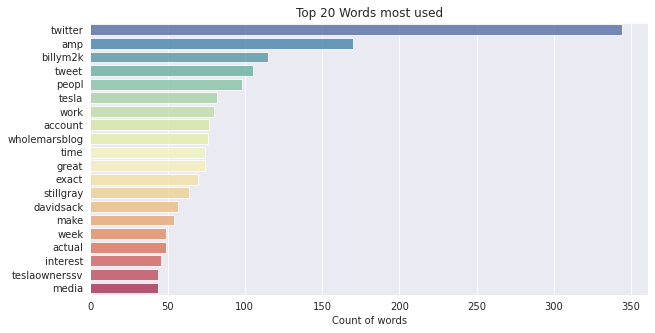

In [48]:
# Bar plot with top 20 words used

y = tx2[0].value_counts()
y = y[:20]

plt.figure(figsize = (10,5))
sns.barplot(y.values, y.index, palette = 'Spectral_r', alpha = 0.8)
plt.title('Top 20 Words most used')
plt.xlabel('Count of words')

### Top persons mentioned in tweets using spacy (NLP)

In [49]:
# Importing spacy for entity recognition on text data
import spacy
from spacy import displacy

In [50]:
# Download spacy model
#!python -m spacy download en_core_web_sm

In [51]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

In [52]:
# Convert list into a string
string = ' '
text = string.join(lines2) # using lines2 instead of stem2 because it contains words unprocessed (more clear to the model)

# Converting text into a doc
doc = nlp(text)

# Creating a loop to store entity and label into lists
words = []
labels = []

for ent in doc.ents:
  words.append(ent.text)
  labels.append(ent.label_)

# Save info into a new dataframe
tx3 = pd.DataFrame({'Words':words,'Labels':labels})

In [53]:
# Show dataframe
tx3.head(10)

,Words,Labels
0,RichardDawkins,ORG
1,Twitter,GPE
2,Twitter,PERSON
3,Designed for Bladerunner Twice,ORG
4,Japan,GPE
5,last year,DATE
6,Population freefall Rest,ORG
7,LillyPad,ORG
8,12V,CARDINAL
9,48V,CARDINAL


The model has categorized the entities quite well. It is important to remember that no model is perfect so it is possible that some errors may appear.

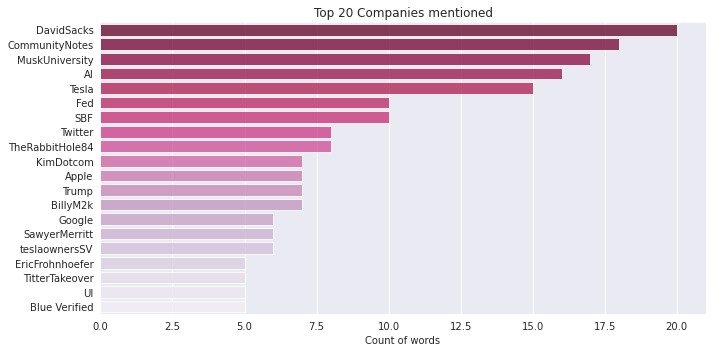

In [54]:
# Plotting companies most mentioned in tweets

y = tx3[tx3['Labels'] == 'ORG']['Words'].value_counts()
y = y[:20]

plt.figure(figsize = (10,5))
sns.barplot(y.values, y.index, palette = 'PuRd_r', alpha = 0.8)
plt.title('Top 20 Companies mentioned')
plt.xlabel('Count of words')

plt.tight_layout()

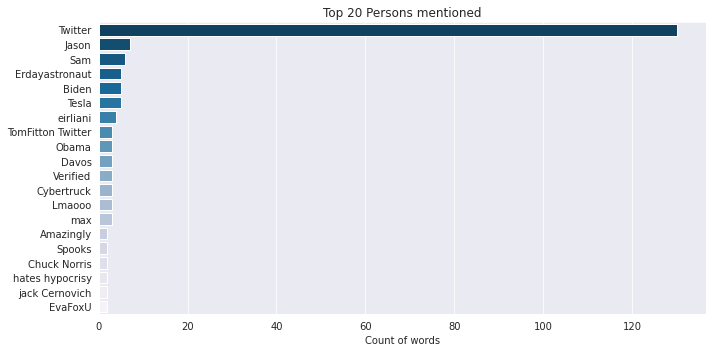

In [55]:
# Plotting persons most mentioned in tweets

y = tx3[tx3['Labels'] == 'PERSON']['Words'].value_counts()
y = y[:20]

plt.figure(figsize = (10,5))
sns.barplot(y.values, y.index, palette = 'PuBu_r')
plt.title('Top 20 Persons mentioned')
plt.xlabel('Count of words')

plt.tight_layout()